## Requirements Setup

In [1]:
!git clone https://github.com/joangog/slime.git

Cloning into 'slime'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 300 (delta 24), reused 19 (delta 10), pack-reused 256
Receiving objects: 100% (300/300), 3.71 MiB | 2.62 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
!pip install '/content/slime'

Processing ./slime
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for slime: filename=slime-0.1-py3-none-any.whl size=292586 sha256=ae9f485c6363b18741a4ecc704fda24619cf2dac9e39e4c3f63a23bc43596205
  Stored in directory: /tmp/pip-ephem-wheel-cache-7thgukmv/wheels/9b/75/5b/fac9c5df9eeea7a76d780065b015816b90fcbe92ded3360a0c
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25521 sha256=c26938038f3429881496f931aabf1a0de5d61a77aed23ec1d99429467705df94
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c298c9882bc9b7c62992b74036b2053e16b187624eb35e4ad5efc9dbe52d5ce6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import cv2
import json
import glob
import skimage

from slime import lime_image

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('cuda:', cuda, 'device:', device)

cuda: True device: cuda:0


## Load Dataset

In [152]:
# Image handling functions

def read_img(file_name):
  img = cv2.imread(file_name)
  # img = imagenet_norm(img)
  # if (type(img) is np.ndarray):
  #   i = 0
  #   # img = image.img_to_array(img.copy())
  #   # img = inc_net.preprocess_input(img)
  #   # img = cv2.resize(img, (224, 224))
  #   # img = img.astype(np.float32)
  #   # img = img[:, :, (2, 1, 0)]
  #   # img = img / 255
  # else:
  #   print('image not found - set your path to the image')
  return img

def imagenet_norm(img):
  # Normalise for ImageNet
  mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
  std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
  img = img / 255
  img = (img - mean) / std
  return img

def preprocess(obs, cuda):

    if cuda:
        torch_device = torch.device('cuda:0')
    else:
        torch_device = torch.device('cpu')

    # Format properly
    if obs.ndim == 4:
      obs = np.transpose(obs, (0, 3, 1, 2))
    elif obs.ndim == 3:
      obs = np.transpose(obs, (2, 0, 1))
      obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=torch_device)

    return obs_tensor

In [153]:
# Load images
imgs = [read_img(img_path) for img_path in glob.glob("/content/gdrive/MyDrive/PCAM imgs/*.png")]
img = read_img('/content/gdrive/MyDrive/PCAM imgs/img10.png')

# Load ImageNet labels
with open('/content/gdrive/MyDrive/SLIME/labels.json') as f:
  label_data = json.load(f)

# Load classifier
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
model = model.to(device)

_ = model.eval()

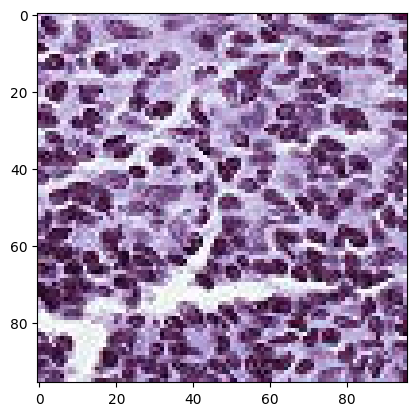

In [154]:
plt.imshow(img)

## Explanation Generation

In [155]:
# Helper functions for S-LIME

def predict(input, model, cuda):
  output = model(input)
  output = F.softmax(output, dim=1)
  return output


def vgg19_predict(input):
  input = preprocess(input, cuda)  # cuda from outer scope
  output = predict(input, model, cuda)  # model from outer scope
  output = np.array(output.detach().cpu())
  return output


def explain_top_labels(img_explanations, lime_type):

  if type(img_explanations).__name__ != 'list':  # If not list and just one element, convert to 1-element list
    img_explanations = [img_explanations]

  fig, axs = plt.subplots(len(img_explanations),len(img_explanations[0].score))
  if lime_type == 'lime':
    fig.suptitle('LIME Explanations',  y=0.96, size='xx-large')
  elif lime_type == 'slime':
    fig.suptitle('S-LIME Explanations', y=0.96, size='xx-large')
  fig.set_figheight(3*len(img_explanations))
  fig.set_figwidth(15)

  for i, img_explanation in enumerate(img_explanations):

    print(f'Seed {i+1}:')

    # Sort labels based on score
    topk_labels = sorted(img_explanation.score.items(), key=lambda x:x[1], reverse=True)
    k = len(topk_labels)

    # Get masked image for each label
    masked_imgs = []
    for j in range(0,k):
      img, mask = img_explanation.get_image_and_mask(topk_labels[j][0])
      mask = np.expand_dims(mask, axis=-1).repeat(3, axis=-1) == 1
      masked_img = np.full(img.shape, (234,249,255))
      masked_img[mask] = img[mask]
      masked_imgs.append(masked_img)

    print(f'   Top-{k} Labels Predicted:')
    for l, label in enumerate(topk_labels):
      print(f'      {l+1}th Class: "{label_data[str(label[0])][1]}", Score: {round(label[1],2)}')
    print()


    # Plot the masked images for each label and for each explanation

    for j in range(0,k):
      if len(img_explanations) == 1:
        axs_i = axs
      else:
        axs_i = axs[i]

      axs_i[0].text(-25, 90, f'Seed {i+1}', rotation='vertical', va='center')
      axs_i[j].imshow(masked_imgs[j])
      axs_i[j].set_title(f'#{j+1} : "{label_data[str(topk_labels[j][0])][1]}"')
      axs_i[j].axis('off')
      axs_i[j].spines['top'].set_visible(True)
      axs_i[j].spines['bottom'].set_visible(True)
      axs_i[j].spines['left'].set_visible(True)
      axs_i[j].spines['right'].set_visible(True)

  # Plot the original image and the segments (only once, from the first seed)
  fig_, axs_ = plt.subplots(1,2)
  fig_.set_figheight(3)
  fig_.set_figwidth(6)
  axs_[0].set_title('Original')
  axs_[0].imshow(img)
  axs_[1].set_title('Features (Superpixels)')
  axs_[1].imshow(skimage.segmentation.mark_boundaries(img, img_explanations[0].segments))

  for j in [0,1]:
    axs_[j].axis('off')
    axs_[j].spines['top'].set_visible(True)
    axs_[j].spines['bottom'].set_visible(True)
    axs_[j].spines['left'].set_visible(True)
    axs_[j].spines['right'].set_visible(True)


### Hyperparameters

In [156]:
# Hyperparameters

num_samples = 150  # Number of samples to take around each data point
top_features = 70   # Top-k superpixels in explanation
top_labels = 5  # Top-k labels to produce explanations for


### LIME results

Seed 1:


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 1:
   Top-5 Labels Predicted:
      1th Class: "microphone", Score: 0.55
      2th Class: "strainer", Score: 0.33
      3th Class: "chain_mail", Score: 0.28
      4th Class: "thimble", Score: 0.09
      5th Class: "water_bottle", Score: 0.08



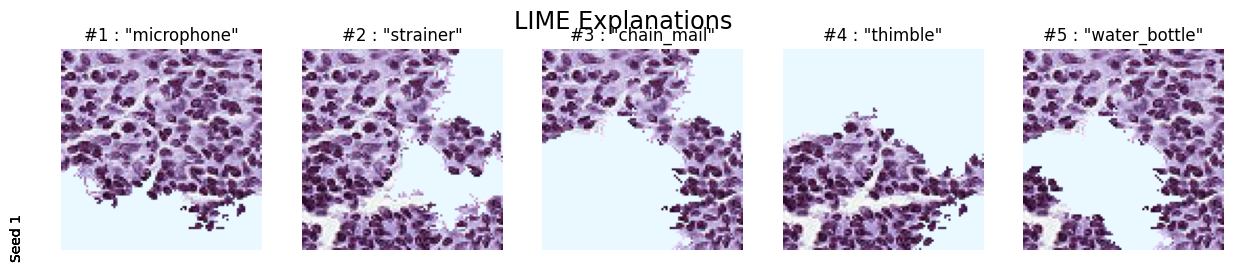

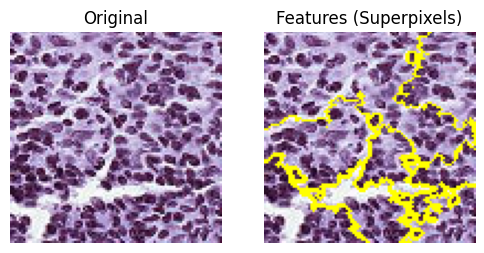

In [157]:
seeds = [1]
explanations_lime = []

explainer = lime_image.LimeImageExplainer(feature_selection = "lasso_path")

for seed in seeds:
  print(f'Seed {seed}:')
  np.random.seed(seed)
  explanations_lime.append(explainer.explain_instance(img, vgg19_predict, labels=tuple([i for i in range(top_labels)]), top_labels=top_labels, num_features = top_features, num_samples = num_samples, random_seed=seed))
explain_top_labels(explanations_lime, 'lime')